In [1]:
!pip install qiskit
!pip install qiskit_dynamics
!pip install qiskit-nature[pyscf] -U
!pip install pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.7/187.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 MB 10.7 MB/s eta 0:00:00


Quantum computers execute gate operations by deploying electromagnetic pulses at the hardware level. Differentiable Pulse Programming allows for the direct authoring of quantum algorithms at this foundational level. By variationally optimizing the shape, phase, and amplitude of the interactions, specific goals can be more precisely and effectively achieved. This meticulous control and adjustment of pulses can lead to a substantial improvement in algorithm performance and efficiency. Within the Qiskit framework, utilizing a pulse ansatz offers significant advantages over a gate ansatz. The pulse ansatz provides a higher degree of freedom and flexibility by allowing direct manipulation and optimization of the pulses. This heightened control translates into more efficient and noise-resilient quantum computations, offering a distinct advantage in addressing complex quantum algorithms and problems.

In this tutorial we give an example that how to use the Qiskit Dynamics to implement a parameterized pulse ansatz to solve a VQE task. In particular, we demonstrate how to build up the parameterized pulse circuit on a DynamicsBackend to simulate pulse schedules, circuits whose gates have pulse definitions, and calibration and characterization experiments from Qiskit Experiments.

# 1. Setup the DynamicBackend

Note that we can import the backend configuration from a real machine to the DynamicsBackend, and we could use JAX to accelearate the simualtion progress, seethe User Guide entry on using JAX with Dynamics for more information.

In [2]:
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax
from qiskit.providers.fake_provider import *

/usr/local/lib/python3.10/dist-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [3]:
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax
from qiskit.providers.fake_provider import *

gate_backend = FakeManila()
gate_backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2}
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")
pulse_backend = DynamicsBackend.from_backend(gate_backend, evaluation_mode="sparse")
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}
pulse_backend.set_options(solver_options=solver_options)
pulse_backend.configuration = lambda: gate_backend.configuration()

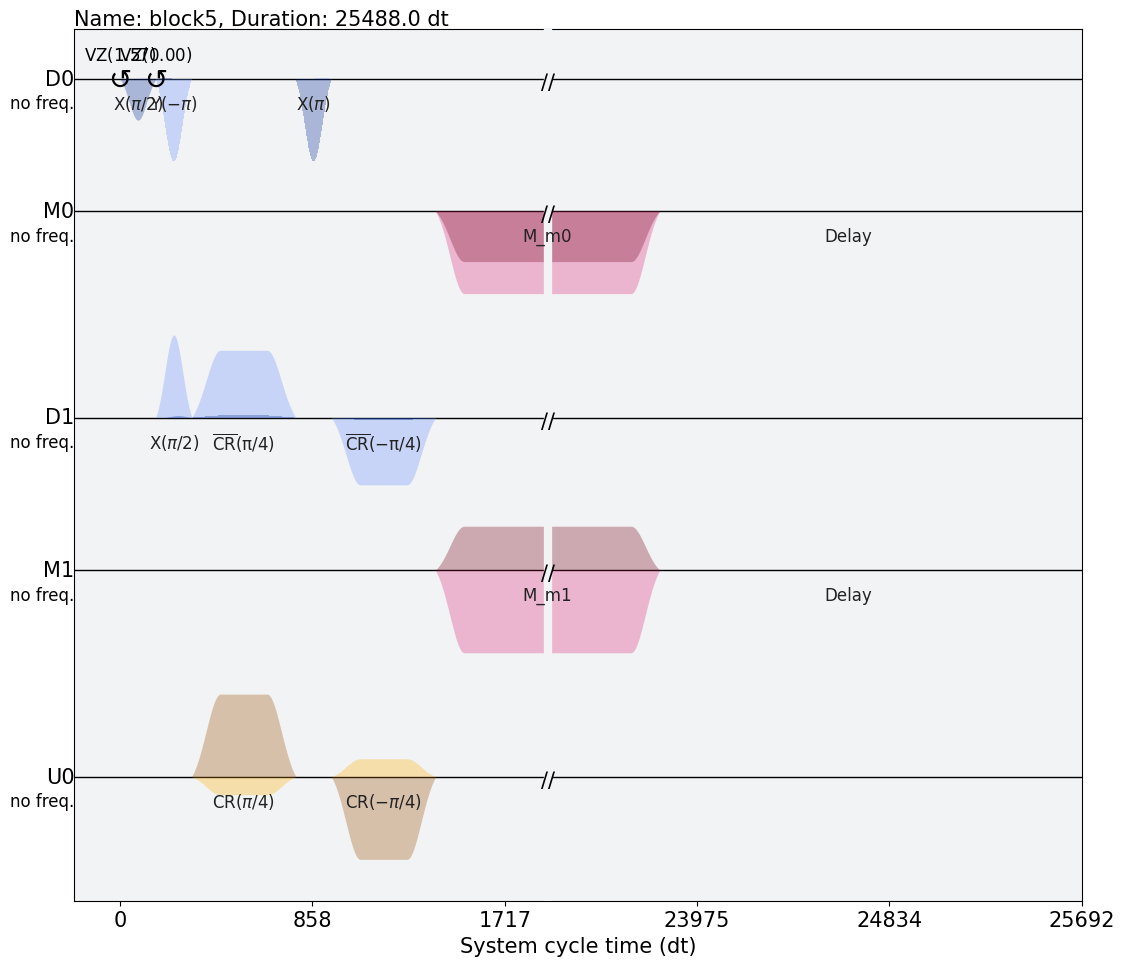

In [4]:
from qiskit import QuantumCircuit, pulse
from qiskit_dynamics.backend import DynamicsBackend

qc_test = QuantumCircuit(2)
qc_test.h(0)
qc_test.cx(0,1)
qc_test.measure_all()
with pulse.build(gate_backend) as pulse_test:
  pulse.call(qc_test)

pulse_test.draw()

In [5]:
results = pulse_backend.run(pulse_test).result()
counts = results.get_counts()

In [6]:
print(counts)

{'00': 151, '01': 196, '10': 144, '11': 533}


# Variational quantum eigensolver with pulse ansatz


We now harness the capacity to execute the Variational Quantum Eigensolver (VQE) at the pulse level. For a comprehensive introduction to VQE, refer to 'A Brief Overview of VQE'. Initially, we outline the molecular Hamiltonian whose energy expectation value is to be minimized. This functions as our objective Hamiltonian. In this context, we employ H2 as a basic example for demonstration purposes.

In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper,ParityMapper,QubitConverter
import numpy as np
ultra_simplified_ala_string = """
H 0.0 0.0 0.0
H 0.0 0.0 0.735
"""

driver = PySCFDriver(
    atom=ultra_simplified_ala_string.strip(),
    basis='sto3g',
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)
qmolecule = driver.run()

/usr/local/lib/python3.10/dist-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
hamiltonian = qmolecule.hamiltonian
coefficients = hamiltonian.electronic_integrals
second_q_op = hamiltonian.second_q_op()
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
qubit_op = converter.convert(second_q_op)
print(qubit_op)
dict = {}
for pauli_op in qubit_op.to_pauli_op().oplist:
        str_info = pauli_op.__str__()
        dict[str_info[-4:]] = float(str_info[0:-6])

-0.8105479805373275 * IIII
+ 0.1721839326191556 * IIIZ
- 0.2257534922240239 * IIZZ
+ 0.17218393261915554 * IZZI
- 0.2257534922240239 * ZZII
+ 0.12091263261776629 * IIZI
+ 0.16892753870087907 * IZZZ
+ 0.04523279994605784 * ZXIX
- 0.04523279994605784 * IXZX
- 0.04523279994605784 * ZXZX
+ 0.04523279994605784 * IXIX
+ 0.16614543256382414 * ZZIZ
+ 0.16614543256382414 * IZIZ
+ 0.17464343068300445 * ZZZZ
+ 0.12091263261776629 * ZIZI


<ipython-input-9-1a3f3beef9f3>:5: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
/usr/local/lib/python3.10/dist-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


We adopt the native pulse as our basis pulses to establish the pulse circuit, since native pulses are well calibrated, we can safely use and modify the pulse shape with minimum energy leakage.

In [ ]:
from qiskit.pulse import Schedule, GaussianSquare, Drag, Delay, Play, ControlChannel, DriveChannel

def drag_pulse(backend, amp, angle):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  pulse1 = Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp, angle=angle)
  return pulse1

def cr_pulse(backend, amp, angle, duration):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  cr_params = {}
  cr_params['duration'] = cr_pulse.parameters['duration']
  cr_params['amp'] = cr_pulse.parameters['amp']
  cr_params['angle'] = cr_pulse.parameters['angle']
  cr_params['sigma'] = cr_pulse.parameters['sigma']
  cr_params['width'] = cr_pulse.parameters['width']
  cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
  angle_parameter = angle
  duration_parameter =  duration
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = int(duration_parameter - 2 * cr_risefall * cr_params['sigma'])
  #declare pulse parameters and build GaussianSquare pulse
  pulse1 = GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter)
  return pulse1

HE_pulse is inspired by hardware efficient ansatz on gate level, you can replace it with any custom pulse circuit.

In [ ]:
def HE_pulse(backend, amp, angle, width):
    with pulse.build(backend) as my_program1:
      # layer 1
      sched_list = []
      with pulse.build(backend) as sched1:
          qubits = (0,1,2,3)
          for i in range(4):
              pulse.play(drag_pulse(backend, amp[i], angle[i]), DriveChannel(qubits[i]))
      sched_list.append(sched1)

      with pulse.build(backend) as sched2:
          uchan = pulse.control_channels(0, 1)[0]
          pulse.play(cr_pulse(backend,amp[4], angle[4], width[0]), uchan)
      sched_list.append(sched2)


      with pulse.build(backend) as sched4:
          uchan = pulse.control_channels(1, 2)[0]
          pulse.play(cr_pulse(backend, amp[5], angle[5], width[1]), uchan)
      sched_list.append(sched4)

      with pulse.build(backend) as sched6:
          uchan = pulse.control_channels(2,3)[0]
          pulse.play(cr_pulse(backend, amp[6],angle[6], width[2]), uchan)
      sched_list.append(sched6)


      with pulse.build(backend) as my_program:
        with pulse.transpiler_settings(initial_layout= [0,1,2,3]):
          with pulse.align_sequential():
              for sched in sched_list:
                  pulse.call(sched)

    return my_program

Here we build the observable for pulse-level VQE, you can do the calibration for X, Y observble for more accurate result by conduct calibration experiemnt via ibm-experiment, but since we do VQE on pulse level, the under-rotation or over-rotation should be migitated during the pulse tuning process.

In [ ]:
import copy
from scipy.optimize import minimize, LinearConstraint

def measurement_pauli(prepulse, pauli_string, backend, n_qubit):
    with pulse.build(backend) as pulse_measure:
        pulse.call(copy.deepcopy(prepulse))
        for ind,pauli in enumerate(pauli_string):
            if(pauli=='X'):
                pulse.u2(0, np.pi, ind)
            if(pauli=='Y'):
                pulse.u2(0, np.pi/2, ind)
        for qubit in range(n_qubit):
            pulse.barrier(qubit)
        pulse.measure(range(n_qubit))
    return pulse_measure

def n_one(bitstring, key):
    results = 0
    for ind,b in enumerate(reversed(bitstring)):
        if((b=='1')&(key[ind]!='I')):
            results+=1
    return results

def expectation_value(counts,shots,key):
    results = 0
    for bitstring in counts:
        if(n_one(bitstring, key)%2==1):
            results -= counts[bitstring]/shots
        else:
            results += counts[bitstring]/shots
    return results

def run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot):
    results = pulse_backend.run(meas_pulse).result()
    counts = results.get_counts()
    expectation = expectation_value(counts,n_shot,key)
    return expectation

def gen_LC_vqe(parameters):
    lb = np.zeros(parameters)
    ub = np.ones(parameters)
    LC = (LinearConstraint(np.eye(parameters),lb,ub,keep_feasible=False))
    return LC

In [ ]:
def vqe_one(prepulse,n_qubit,n_shot,pulse_backend, backend,key,value):
    all_Is = True
    for key_ele in key:
        if(key_ele!='I'):
            all_Is = False
    if(all_Is):
        return value
    meas_pulse = measurement_pauli(prepulse=prepulse, pauli_string=key, backend=backend, n_qubit=n_qubit)
    return value*run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot)

Here we determine the main fuction of pulse level VQE. And we import the multiprocessing as a option to accelerate the VQE solving process.

In [ ]:
def vqe(params,pauli_dict,pulse_backend, backend,n_qubit,n_shot):
    print("params in def chemistry in vqe.py: ", params)
    # assert(len(params)%2==0)
    width_len = int(len(params)-1*(n_qubit-1))
    split_ind = int(width_len/2)
    amp = np.array(params[:split_ind])
    angle = np.array(params[split_ind:width_len])*np.pi*2
    width_1 = (np.array(params[width_len:]))
    num_items = (1024 - 256) // 16 + 1
    width_norm = (width_1 - 256) / (1024 - 256)
    width_norm = np.clip(width_norm, 0, 1)
    width = (np.round(width_norm * (num_items - 1)) * 16 + 256).astype(int)
    amp = amp.tolist()
    angle = angle.tolist()
    width = width.tolist()
    keys = [key for key in pauli_dict]
    values = [pauli_dict[key] for key in pauli_dict]
    expect_values = []

    for key, value in zip(keys, values):
        prepulse = HE_pulse(backend, amp, angle, width)
        expect = vqe_one(prepulse, n_qubit, n_shot, pulse_backend, backend, key, value)
        expect_values.append(expect)
    print("E for cur_iter: ",sum(expect_values))
    return sum(expect_values)

In [ ]:
n_qubit = 4
parameters = 17
params = np.zeros(parameters)
LC = gen_LC_vqe(parameters)
n_shot = 1024
optimizer = 'COBYLA'
vqe_res = minimize(vqe,params,args=(dict,pulse_backend, gate_backend,n_qubit, n_shot),method=optimizer,
                    constraints=LC,options={'rhobeg':0.2,'maxiter':70,'disp':True})
print(dict)
print('The optimized loss func value: {}'.format(vqe_res.fun))

params in def chemistry in vqe.py:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E for cur_iter:  2.914335439641036e-16
params in def chemistry in vqe.py:  [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  -0.43764938014591714
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  -1.1679111213863476
params in def chemistry in vqe.py:  [0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  -0.49210948106514457
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  -1.0430627755586552
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  -1.1717534137810937
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  -1.1365941045910424
params in de